## Step 1. 데이터 구하기

In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
from scipy.stats import norm
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import copy


In [2]:
#데이터 불러오기

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/NQ=F.csv'

df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6168
삭제 후 데이터 길이(일자수): 5096


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Step 2. 기본 통계분석으로 이상치 찾기

### 데이터의 분포를 그려보기

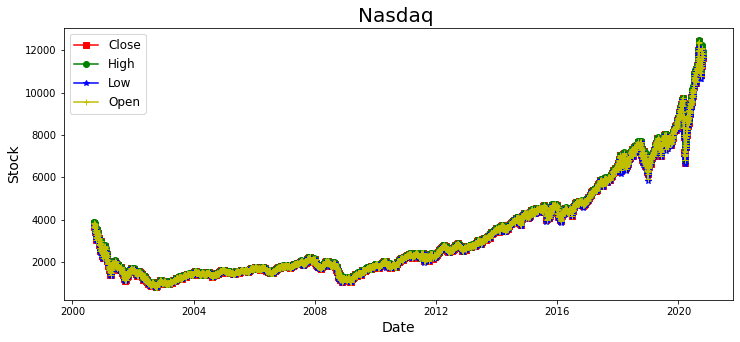

In [5]:
plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Nasdaq ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

눈으로 보이는 이상치는 없다.

0.0


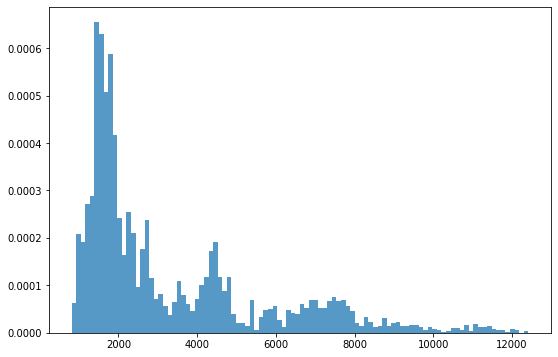

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)
_, p = ztest(df.Close)
print(p)

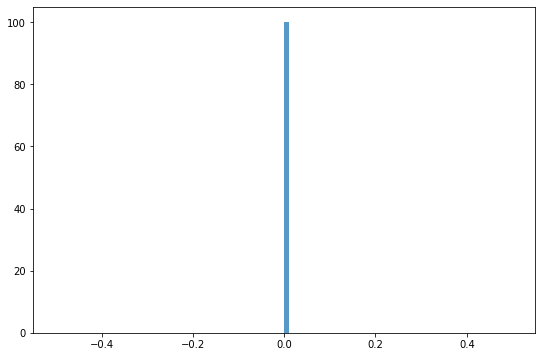

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist([df.Close - df["Adj Close"]], 100, density=True, alpha=0.75)

z = 0.0

패턴 역시 보이지 않으며 조정에 따른 특이치도 관측되지 않는다.

### Time series decompose 수행후 residual로 분석하기

In [8]:
# 계절적 성분은 이평선 중 하나인 60일선(추세선)과 120일선(경기선)을 확인한다.

result_60 = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=60, extrapolate_trend='freq')


result_120 = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=120, extrapolate_trend='freq')


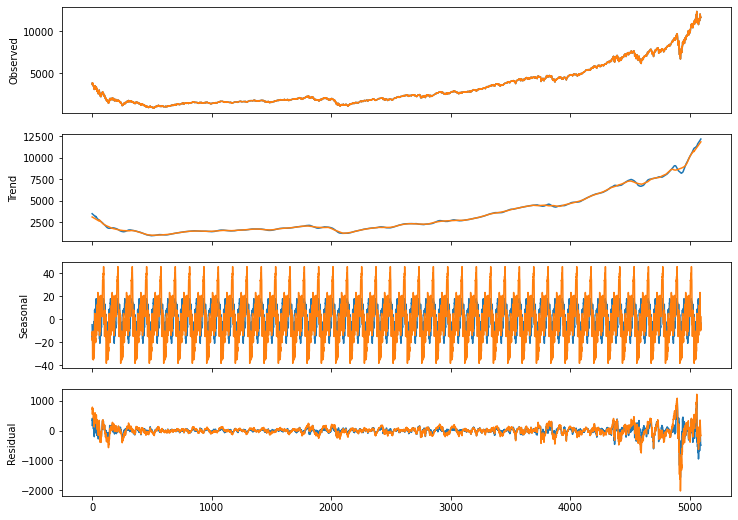

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result_60.observed.plot(ax=axes[0], legend=False)
result_120.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_60.trend.plot(ax=axes[1], legend=False)
result_120.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_60.seasonal.plot(ax=axes[2], legend=False)
result_120.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_60.resid.plot(ax=axes[3], legend=False)
result_120.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

<AxesSubplot:>

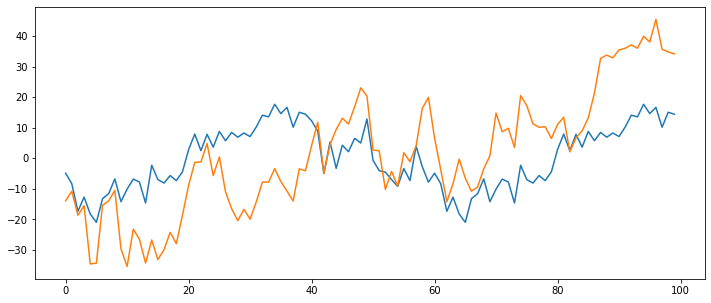

In [10]:
result_60.seasonal[:100].plot()
result_120.seasonal[:100].plot()

<AxesSubplot:>

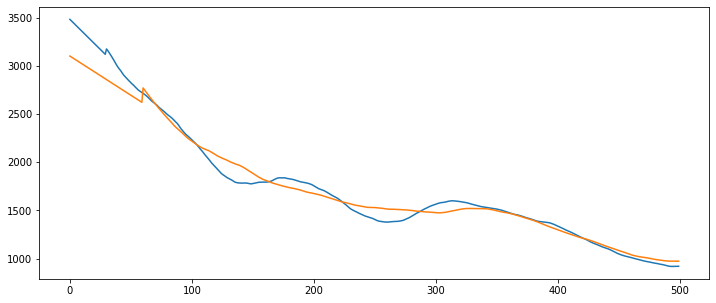

In [11]:
result_60.trend[:500].plot()
result_120.trend[:500].plot()

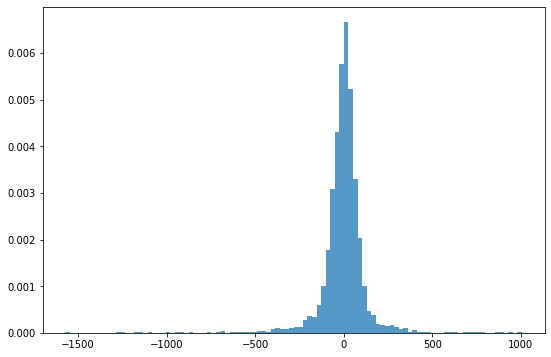

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result_60.resid, 100, density=True, alpha=0.75)

In [13]:
r_60 = result_60.resid.values
st, p = ztest(r_60)
print(st,p)

-0.9962806307530815 0.3191138121503023


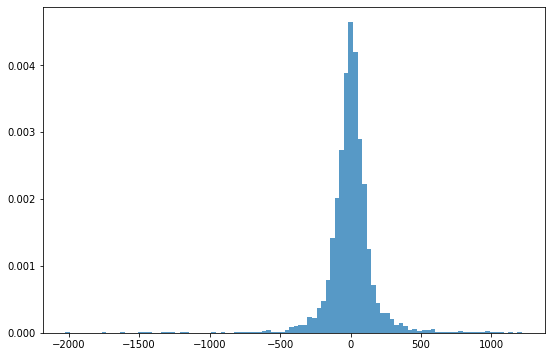

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result_120.resid, 100, density=True, alpha=0.75)

In [15]:
r = result_120.resid.values
st, p = ztest(r)
print(st,p)

0.6985267878043723 0.48484781127287946


p-value가 0.48로 더 높고 trend에서도 이상치에 덜 둔감한 120일선을 기준으로 진행한다.

In [16]:
result = result_120

In [17]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: 1.6802053158495498 표준편차: 171.70937147598653
이상치 갯수: 100


In [18]:
nov = df.Date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]
print(nov)

0      2000-09-18
1      2000-09-19
2      2000-09-20
3      2000-09-21
4      2000-09-22
          ...    
5060   2020-09-01
5061   2020-09-02
5062   2020-09-03
5075   2020-09-23
5076   2020-09-24
Name: Date, Length: 100, dtype: datetime64[ns]


In [19]:
for i in nov:
    print(i)

2000-09-18 00:00:00
2000-09-19 00:00:00
2000-09-20 00:00:00
2000-09-21 00:00:00
2000-09-22 00:00:00
2000-09-25 00:00:00
2000-09-26 00:00:00
2000-09-27 00:00:00
2000-09-28 00:00:00
2000-09-29 00:00:00
2000-10-02 00:00:00
2000-10-05 00:00:00
2000-10-19 00:00:00
2000-10-20 00:00:00
2000-10-23 00:00:00
2000-11-03 00:00:00
2000-11-06 00:00:00
2001-04-03 00:00:00
2001-04-04 00:00:00
2018-12-19 00:00:00
2018-12-20 00:00:00
2018-12-21 00:00:00
2018-12-26 00:00:00
2018-12-27 00:00:00
2018-12-28 00:00:00
2018-12-31 00:00:00
2019-01-02 00:00:00
2019-01-03 00:00:00
2019-06-03 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-19 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00


2000년 9월;
닷컴버블 상승세

2001년 4월 초;
1990년대 후반에 IT산업과 주식시장을 중심으로 형성되었던 거품이 붕괴되면서 2001년 1/4분기부터 3/4분기까지 경기침체를 겪었다. 이로인한 급락이 반영되었다.

2018년 12월~19년 1월초;
블랙 크리스마스. 미연방정부의 업무정지가 장기화될 조짐을 보였으며 연준의장 해임설, 은행 유동성 긴급점검 등이 원인으로 급락하였다.

2020년 1월~4월;
코로나 발생

2020년 9월;
낙폭 회복, 개인 투자자(mom-and-pop traders) 등으로 인한 극단적인 상승세

모든 이상치는 특이치로 판단할 수 있다.

Step 3. Unsupervised Clustering 으로 이상치 찾기
k-means로 분석하기
DBSCAN으로 분석하기

In [20]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000
mean,3327.512658,3358.941625,3295.367706,3329.383898,287923.270493
std,2395.882288,2417.677274,2374.765673,2399.779279,109656.543848
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.310625,1597.597500,1571.086250,1584.247701,220564.000000
50%,2264.381250,2291.505000,2232.175000,2264.864150,268880.140000
75%,4433.875625,4464.944375,4400.526875,4435.201250,319662.102500
max,12052.478481,12208.416091,11883.980606,12057.563021,776809.340000


In [21]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000
mean,-1.422052,-1.417179,-1.302481,-1.352384,165.489930
std,112.667077,102.263238,116.835593,110.404080,110731.135916
min,-1280.382431,-1494.463405,-1226.785755,-1389.989755,-602963.244605
25%,-37.996631,-35.133464,-38.428725,-37.683019,-53343.336321
50%,3.480257,3.418047,4.026657,2.921896,-521.293404
75%,40.219636,37.555488,41.827128,40.827907,51462.061230
max,996.893732,933.614371,941.502303,996.282619,810723.488836


In [22]:
# 표준정규화
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.42205211  -1.41717909  -1.30248052  -1.35238417 165.48993013]


array([[ 0.94540473,  0.84470941,  0.81468464,  0.59993984,  0.08320731],
       [ 0.4884521 ,  1.2815444 ,  1.38400837,  2.08889225,  0.10452429],
       [ 1.90043578,  2.01420382,  2.04161697,  2.72921452, -0.08886585],
       ...,
       [-1.70272759, -2.07032174, -2.17471631, -3.31186325,  0.54881764],
       [-2.94459902, -3.82832989, -2.27504543, -3.39178393,  0.69976619],
       [-3.34009784, -4.17113312, -2.57652574, -3.32791408,  0.69351903]])

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [24]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1021 4075]


### k-mean으로 분석하기

In [25]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:104',
 'group:1-count:454',
 'group:2-count:413',
 'group:3-count:14',
 'group:4-count:51',
 'group:5-count:20',
 'group:6-count:1071',
 'group:7-count:264',
 'group:8-count:297',
 'group:9-count:69',
 'group:10-count:118',
 'group:11-count:1015',
 'group:12-count:511',
 'group:13-count:20',
 'group:14-count:675']

In [26]:
# 20개 이하 그룹 3, 5, 13을 확인
df[(kmeans.labels_==3)|(kmeans.labels_==5)|(kmeans.labels_==13)]

,Date,Open,High,Low,Close,Adj Close,Volume
1639,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0
1742,2007-07-26,2026.500000,2039.500000,1969.250000,2000.500000,2000.500000,808824.0
1816,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0
4325,2017-11-29,6423.500000,6428.500000,6283.000000,6305.500000,6305.500000,625761.0
4369,2018-02-02,6954.000000,6963.500000,6752.250000,6755.750000,6755.750000,642482.0
4579,2018-12-06,6834.500000,6854.250000,6630.250000,6824.500000,6824.500000,986103.0
4650,2019-03-22,7526.750000,7544.750000,7353.000000,7368.750000,7368.750000,694561.0
4681,2019-05-07,7744.750000,7804.000000,7581.250000,7674.000000,7674.000000,838952.0
4740,2019-08-01,7834.000000,8014.500000,7776.750000,7808.250000,7808.250000,772956.0
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0


In [27]:
df[(kmeans.labels_==3)]

,Date,Open,High,Low,Close,Adj Close,Volume
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.750000,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,321230.0
4925,2020-03-23,6798.000000,7316.250000,6628.750000,6984.500000,6984.500000,633237.0
4926,2020-03-24,7005.750000,7572.250000,7005.750000,7554.750000,7554.750000,556553.0


In [28]:
df[(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


group 3과 5는 위에서 찾은 것과 동일한 원인이다.

In [29]:
df[(kmeans.labels_==13)]

,Date,Open,High,Low,Close,Adj Close,Volume
1639,2007-02-27,1837.500000,1838.25,1744.250000,1750.500000,1750.500000,774124.0
1742,2007-07-26,2026.500000,2039.50,1969.250000,2000.500000,2000.500000,808824.0
1816,2007-11-08,2175.000000,2180.00,2081.000000,2105.500000,2105.500000,884081.0
4325,2017-11-29,6423.500000,6428.50,6283.000000,6305.500000,6305.500000,625761.0
4369,2018-02-02,6954.000000,6963.50,6752.250000,6755.750000,6755.750000,642482.0
4579,2018-12-06,6834.500000,6854.25,6630.250000,6824.500000,6824.500000,986103.0
4650,2019-03-22,7526.750000,7544.75,7353.000000,7368.750000,7368.750000,694561.0
4681,2019-05-07,7744.750000,7804.00,7581.250000,7674.000000,7674.000000,838952.0
4740,2019-08-01,7834.000000,8014.50,7776.750000,7808.250000,7808.250000,772956.0
4902,2020-02-25,9091.000000,9224.25,8810.000000,8854.250000,8854.250000,1344897.0


2007-02-26~27
1800중반에서 1700중반으로 100포인트 가량 폭락했다.

In [30]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,2.327086,2.396331,2.442270,2.387824,-0.421899
1,-0.414420,-0.463377,-0.331603,-0.375177,-0.813768
2,0.911419,0.938558,0.996783,0.979735,-0.505735
3,-7.967369,-7.377874,-8.146125,-7.397363,-1.595218
4,-3.629658,-3.927733,-3.552818,-3.641110,0.557333
5,6.054841,6.108243,6.105312,6.024936,-0.222417
6,-0.124298,-0.113383,-0.119411,-0.108864,0.274062
7,0.190707,0.181585,0.246722,0.229745,-1.950397
8,-0.056102,-0.079978,-0.314965,-0.297921,1.609738
9,-1.290243,-1.442363,-1.933769,-1.944538,2.875405


### DBSCAN으로 분석하기

In [31]:
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [32]:
print(clustering.labels_)

[ 0  0  0 ... -1  4  4]


In [33]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:199',
 'group:0-count:4839',
 'group:1-count:2',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:4',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:3',
 'group:21-count:2',
 'group:22-count:2']

In [34]:
df[(clustering.labels_==3)|(clustering.labels_==5)|(clustering.labels_==13)]

,Date,Open,High,Low,Close,Adj Close,Volume
65,2000-12-19,2609.50,2686.00,2393.00,2410.00,2410.00,83019.0
76,2001-01-05,2485.00,2551.00,2273.50,2293.50,2293.50,94688.0
1639,2007-02-27,1837.50,1838.25,1744.25,1750.50,1750.50,774124.0
1816,2007-11-08,2175.00,2180.00,2081.00,2105.50,2105.50,884081.0
4553,2018-10-26,6882.00,6986.50,6734.25,6893.25,6893.25,1069548.0
4744,2019-08-07,7512.75,7577.50,7387.50,7553.25,7553.25,851275.0


In [35]:
for i in range(1, 23):
    print(df[(clustering.labels_==i)])

         Date    Open    High     Low   Close  Adj Close   Volume
41 2000-11-14  2826.0  3068.0  2825.0  3057.5     3057.5  72323.0
55 2000-12-05  2563.0  2857.0  2530.0  2840.0     2840.0  93557.0
           Date     Open     High      Low    Close  Adj Close    Volume
52   2000-11-30  2508.50  2589.00  2435.00  2530.00    2530.00  105511.0
66   2000-12-20  2415.00  2445.50  2234.50  2269.00    2269.00   91112.0
67   2000-12-21  2275.50  2390.00  2211.00  2282.50    2282.50   92544.0
77   2001-01-08  2290.00  2328.00  2171.00  2325.00    2325.00   92841.0
136  2001-04-03  1521.50  1527.00  1402.00  1405.00    1405.00  132338.0
138  2001-04-05  1390.00  1537.00  1382.00  1514.50    1514.50  132812.0
139  2001-04-06  1522.00  1544.00  1437.00  1467.00    1467.00  141183.0
140  2001-04-09  1471.50  1512.50  1439.00  1499.50    1499.50  157636.0
4375 2018-02-12  6434.50  6567.50  6414.25  6531.75    6531.75  406083.0
4376 2018-02-13  6529.75  6571.00  6470.75  6560.50    6560.50  382334.0

2014-10-13~14 데이터 확인결과 이상 없다.

그 이외에 전체 평균치에서도 유의미한 이상치는 발견되지 않는다.

## Step 4. LSTM 오토인코더로 이상치 찾기

### 딥러닝을 위한 데이터셋 만들기

In [36]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [37]:
# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [38]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


### 오토인코더 모델 생성하기

In [39]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [40]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [41]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.5318 - mae: 1.5318
Epoch 00001: val_loss improved from inf to 1.09210, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 32ms/step - loss: 1.5318 - mae: 1.5318 - val_loss: 1.0921 - val_mae: 1.0921
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 0.6106 - mae: 0.6106
Epoch 00002: val_loss improved from 1.09210 to 0.59467, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 0.6106 - mae: 0.6106 - val_loss: 0.5947 - val_mae: 0.5947
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.4214 - mae: 0.4214
Epoch 00003: val_loss did not improve from 0.59467
159/159 [==============================] - 5s 29ms/step - loss: 0.4214 - mae: 0.4214 - val_loss: 0.6467 - val_mae: 0.6467
Epoch 4/50
159/159 [==========================

In [42]:
model.load_weights(checkpoint_path)

### 학습이 정상적으로 수행됐는지 확인하기

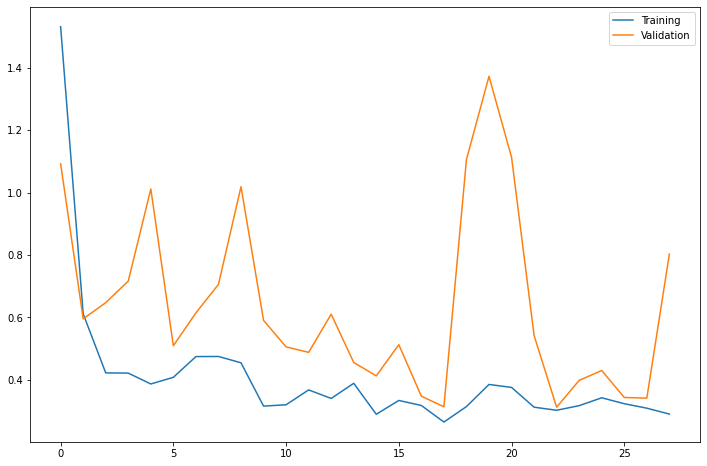

In [43]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

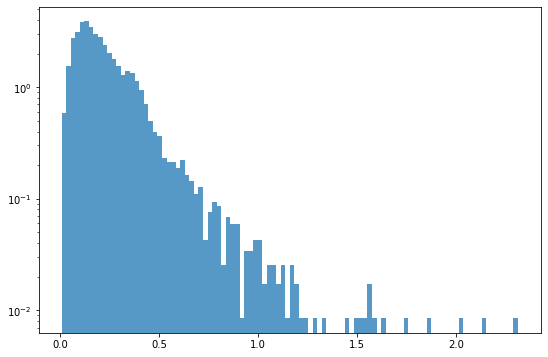

In [44]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [45]:
test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1747,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.176901
1806,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0,1.068589
3534,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.129678
3747,2015-08-24,4183.750000,4196.250000,3908.250000,4003.250000,4003.250000,746533.0,1.279760
4360,2018-02-05,6752.250000,6813.500000,6387.750000,6429.250000,6429.250000,931677.0,1.198688
4396,2018-03-28,6550.250000,6582.250000,6421.000000,6477.250000,6477.250000,948120.0,1.119057
4531,2018-10-10,7394.750000,7412.000000,7000.000000,7032.000000,7032.000000,924204.0,1.078711
4532,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.555187
4543,2018-10-26,6882.000000,6986.500000,6734.250000,6893.250000,6893.250000,1069548.0,1.167304
4560,2018-11-20,6668.500000,6670.000000,6449.500000,6532.500000,6532.500000,910469.0,1.076166


In [46]:
threshold = 0.7
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1629,2007-02-27,1837.5,1838.250000,1744.250000,1750.500000,1750.500000,774124.0,0.843377
1732,2007-07-26,2026.5,2039.500000,1969.250000,2000.500000,2000.500000,808824.0,0.871613
1747,2007-08-16,1877.5,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.176901
1806,2007-11-08,2175.0,2180.000000,2081.000000,2105.500000,2105.500000,884081.0,1.068589
1850,2008-01-16,1880.0,1919.250000,1859.250000,1881.000000,1881.000000,707613.0,0.722434
...,...,...,...,...,...,...,...,...
5060,2020-09-16,11467.5,11550.000000,11237.500000,11268.799805,11268.799805,167828.0,1.002173
5061,2020-09-17,11269.5,11302.500000,10918.799805,11090.000000,11090.000000,157390.0,1.234223
5062,2020-09-18,11082.0,11179.200195,11037.200195,11144.799805,11144.799805,800279.0,0.800243
5063,2020-09-21,10920.0,11009.799805,10656.500000,10989.000000,10989.000000,727984.0,0.981649


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


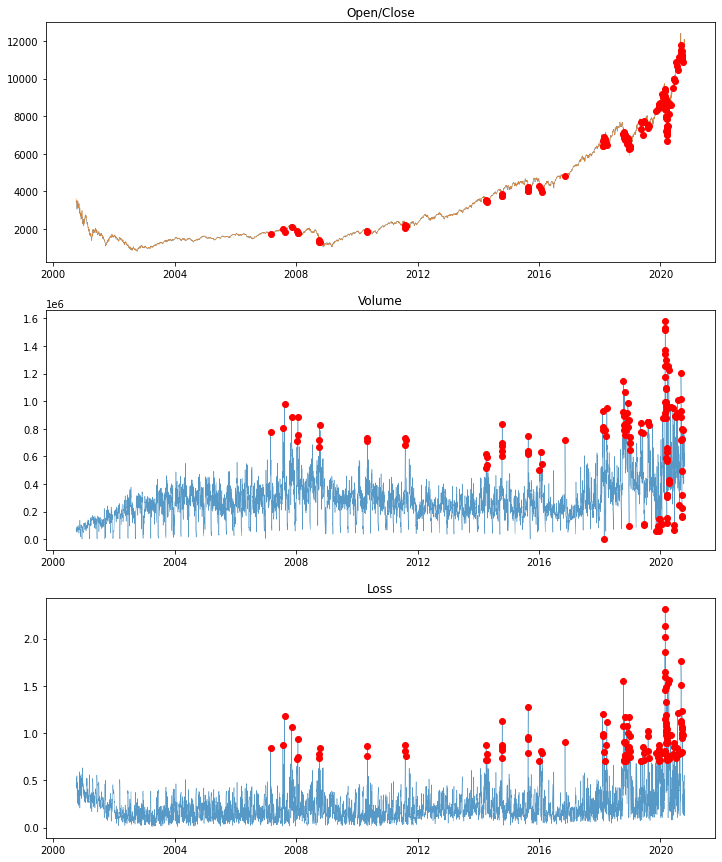

In [47]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

앞선 k-mean과 DBSCAN과 비교했을때 주된 포인트는 거의 동일하게 잡아내는 것을 확인 할 수 있었다.

### 차이점
k-mean과 DBSCAN이 잡아내지 못한 2007년 데이터는 loss와 volume에서 특이점이 발견된 지점이었으나 close 중심의 데이터 분석을 진행한 k-mean과 DBSCAN은 이를 온전히 수행하지 못하였다.